In [1]:
from dm_control import mjcf
from dm_control import mujoco
from dm_control.mujoco.wrapper.mjbindings import enums


#General
import numpy as np
import pandas as pd
import os
import math


#Graphics-related
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import PIL.Image

# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)


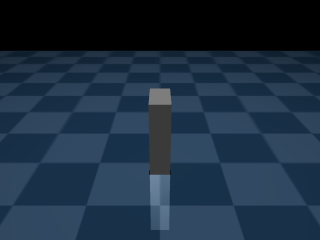

In [2]:
block_on_floor = """
<mujoco model="block_on_floor">
  <option integrator="Euler"/>
  <option timestep="5e-05" gravity = "0 0 +9.81" integrator="Euler" solver="Newton" iterations="1000" tolerance="1e-12" noslip_iterations="100" noslip_tolerance="1e-08" mpr_iterations="100"/>
  <compiler boundmass="1e-06" boundinertia="1e-06" angle="radian" eulerseq="xyz" discardvisual="true" convexhull="true" fusestatic="true"/>
  <size njmax="4096" nconmax="4096"/>
    <visual>
    <global offwidth="1280" offheight="720"/>
    <quality shadowsize="1024" offsamples="4" numslices="28" numstacks="16" numquads="4"/>
    <map stiffness="100.0" stiffnessrot="500.0" force="2.0" torque="0.001" alpha="0.3" fogstart="3.0" fogend="10.0" znear="0.1" zfar="3000.0" haze="0.3" shadowclip="1.0" shadowscale="0.3" actuatortendon="2.0"/>
    <scale forcewidth="12.0" contactwidth="12.0" contactheight="50.0" connect="1.0" com="1.0" camera="1.0" light="1.0" selectpoint="1.0" jointlength="1.0" jointwidth="1.0" actuatorlength="1.0" actuatorwidth="1.0" framelength="0.01" framewidth="0.01" constraint="0.01" slidercrank="0.01"/>
  </visual>
  <statistic meanmass="1.0" meaninertia="1.0" meansize="1.0"/>
  <default>
    <default class="nmf"/>
  </default>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>
  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="-7.48e-18  1.21e-16  0.0149">
      <freejoint/>
      <geom name="box" type="box" size="0.004 .008 0.015"/>
    </body>
  </worldbody>
  <actuator>
    <adhesion name="adhere_box_floor" body="top" ctrlrange="0.001 0.003" gain="15"/> 
  </actuator> 

</mujoco>
"""
model_block = mjcf.from_xml_string(block_on_floor)
physics = mjcf.Physics.from_mjcf_model(model_block)
#physics = mujoco.Physics.from_xml_string(block_on_floor)
PIL.Image.fromarray(physics.render(camera_id='closeup'))

#the block sticks to the floor at 0.002 and flies away at 0.002

#gravity is by default implemented as [0.    0.   -9.81], you can check by using: physics.model.opt.gravity

In [3]:
physics.named.data.xpos

FieldIndexer(xpos):
          x         y         z         
0 world [ 0         0         0       ]
1   top [-7.48e-18  1.21e-16  0.0149  ]

In [4]:
physics.model.opt.gravity

array([0.  , 0.  , 9.81])

In [5]:
adhesion_actuators = [actuator for actuator in model_block.find_all('actuator')
             if actuator.tag == 'adhesion']

In [6]:
adhesion_actuators

[MJCF Element: <adhesion name="adhere_box_floor" class="/" ctrlrange="0.001 0.0030000000000000001" body="top" gain="15"/>]

In [122]:
#@title Video of the tippe-top {vertical-output: true}

duration = 4    # (seconds)
framerate = 60  # (Hz)
time_change_adhesion = 2
tol = 0.00001

# Simulate and display video.
frames = []
physics.reset()  # Reset to keyframe 0 (load a saved state). -> 0 wont work because I dont save the state
while physics.data.time < duration:

  #if math.isclose(time_change_gravity, physics.data.time, rel_tol=tol):
    #print(physics.model.opt.gravity)
    #physics.model.opt.gravity[2] *= -1
    #print(physics.model.opt.gravity)
    
  for adh_act in adhesion_actuators:
    if time_change_adhesion < physics.data.time:
      physics.bind(adh_act).ctrl = 0
    else: 
      physics.bind(adh_act).ctrl = 1


  physics.step()
  if len(frames) < (physics.data.time) * framerate:
    pixels = physics.render(camera_id='closeup')
    frames.append(pixels)
#display_video(frames, framerate)

In [123]:
display_video(frames, framerate)

In [75]:
physics.reset()

In [76]:
physics.data.time

0.0

In [73]:
display_video(frames, framerate)

In [72]:
physics.model.opt.gravity

array([0.  , 0.  , 9.81])

In [38]:
physics.named.data.xpos #first put the gravity negative -> use the resulting position as the position of contact. Then change the gravity direction

FieldIndexer(xpos):
          x         y         z         
0 world [ 0         0         0       ]
1   top [-7.48e-18  1.21e-16  0.0149  ]

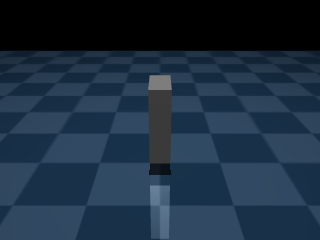

In [9]:
PIL.Image.fromarray(frames[2])

In [10]:
physics.model.opt.gravity[2] *= -1

In [11]:
len(frames)

421

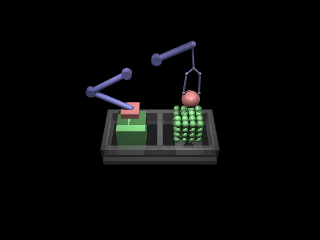

In [25]:
Active_adhesion_example = """

<mujoco model="Active adhesion example">
  <!--
    Adding some fluid viscosity to prevent the hanging sphere from jiggling too much.
  -->
  <option viscosity="1"/>

  <size memory="10M"/>

  <visual>
    <headlight diffuse=".2 .2 .2"/>
  </visual>

  <default>
    <joint damping=".3" axis="0 1 0"/>
    <geom type="box" friction=".5"/>
    <default class="wall">
      <geom rgba=".5 .5 .5 .4"/>
    </default>
    <default class="mechanical">
      <geom rgba=".5 .5 .8 1"/>
      <tendon rgba=".5 .5 .8 1"/>
    </default>
    <default class="active_adhesion">
      <!--
        Geoms in the active_adhesion class are "inflated" with a margin of 1cm, but contacts are
        activated only at a depth gap of 1cm, leading to a layer of inactive contacts at a 1cm
        distance from the surface. However the contacts can be used by the adhesion actuator.
      -->
      <geom rgba=".8 .5 .5 1" margin=".01" gap=".01"/>
    </default>
    <default class="object">
      <geom rgba=".5 .8 .5 1" density="100"/>
    </default>
  </default>

  <worldbody>
    <light pos="0.4 -.15 .6" dir="-1 .5 -1" diffuse=".7 .7 .7"/>
    <light pos="-.4 -.15 .6" dir="1 .5 -1" diffuse=".7 .7 .7"/>

    <body name="two crates">
      <joint name="conveyor" type="slide" damping="100" axis="1 0 0"/>
      <geom size=".2 .1 .01" pos="0 0 -.01"/>
      <geom size=".01 .08 .031" pos="-.19 0 .03" class="wall"/>
      <geom size=".01 .08 .031" pos="0  0 .03" class="wall"/>
      <geom size=".01 .08 .031" pos="0.19 0 .03" class="wall"/>
      <geom size="0.2 .01 .031" pos="0 -.09 .03" class="wall"/>
      <geom size="0.2 .01 .031" pos="0 0.09 .03" class="wall"/>
    </body>

    <body name="arm1" pos="-.1 0 .3" childclass="mechanical">
      <joint name="arm1"/>
      <geom type="cylinder" size=".015 .01" zaxis="0 1 0"/>
      <geom type="capsule" size=".01" fromto="0 0 0 -.12 0 -.07"/>
      <body name="arm2" pos="-.12 0 -.07">
        <joint name="arm2"/>
        <geom type="cylinder" size=".015 .01" zaxis="0 1 0"/>
        <geom type="capsule" size=".01" fromto="0 0 0 .12 0 -.07"/>
        <body name="4boxes" pos=".12 0 -.08" childclass="active_adhesion">
          <site name="force_sensor" group="3"/>
          <joint name="arm3" damping=".01" pos="0 -.03 0"/>
          <geom size=".015 .015 .01" pos="0.015 0.015 0"/>
          <geom size=".015 .015 .01" pos="0.015 -.015 0"/>
          <geom size=".015 .015 .01" pos="-.015 0.015 0"/>
          <geom size=".015 .015 .01" pos="-.015 -.015 0"/>
        </body>
      </body>
    </body>

    <body name="box" pos="-.1 0 .05">
      <freejoint/>
      <geom size=".05 .05 .05" class="object"/>
    </body>

    <body name="winch" pos="-.01 0 .35" childclass="mechanical">
      <joint name="winch" damping="1"/>
      <geom type="cylinder" size=".015 .01" zaxis="0 1 0"/>
      <geom type="capsule" size=".01" fromto="0 0 0 .1 0 .05"/>
      <site name="anchor" pos=".1 0 .04"/>
    </body>
    <site name="pulley" pos=".1 0 .32"/>
    <site name="hook_left" pos=".08 0 .3"/>
    <site name="hook_right" pos=".12 0 .3"/>
    <body name="sphere" pos=".1 0 .2" childclass="active_adhesion">
      <freejoint/>
      <!--
        The composite balls in the crate have only 3 linear DoFs with condim=1, effectively
        frictionless point particles. In order to make them stick to the sphere we give the sphere
        priority 2, to force condim=3.
        Also note the sphere has a margin+gap of 3cm as opposed to the 1cm of the arm box.
      -->
      <geom type="sphere" size=".03" priority="2" margin=".03" gap=".03"/>
      <site name="pin_left" pos="-.025 0 .025"/>
      <site name="pin_right" pos=".025 0 .025"/>
    </body>

    <composite type="particle" count="4 4 4" spacing="0.025" offset=".11 .01 .1">
      <geom size=".012" rgba=".5 .8 .5 1" solref=".005 1"/>
    </composite>
  </worldbody>

  <equality>
    <joint joint1="arm1" joint2="arm2" polycoef="0 -.5 0 0 0"/>
    <joint joint1="arm3" joint2="arm1"/>
  </equality>

  <!--
    By using divisor=3 in the pullies we increase the distance by which the hanging sphere moves
    relative to the motion of the winch arm. One should imagine a double spindle with two radii that
    creates a ratio of 1.5 between the motion of tendon before the pullies and after the pullies.
    (1.5 rather than 3 because the tendon has 2 branches and the length is split between them)
  -->
  <tendon>
    <spatial range="0 .19" limited="true" solreflimit=".01 2" class="mechanical">
      <site site="anchor"/>
      <site site="pulley"/>
      <pulley divisor="3"/>
      <site site="pulley"/>
      <site site="hook_left"/>
      <site site="pin_left"/>
      <pulley divisor="3"/>
      <site site="pulley"/>
      <site site="hook_right"/>
      <site site="pin_right"/>
    </spatial>
  </tendon>

  <actuator>
    <position name="conveyor" joint="conveyor" ctrlrange="-.2 .2" ctrllimited="true" kp="400"/>
    <position name="arm" joint="arm2" ctrlrange="-.8 1" ctrllimited="true" kp="10"/>
    <adhesion name="adhere_arm" body="4boxes" ctrlrange="0 1" gain="5"/>
    <position name="winch" joint="winch" ctrlrange="-.7 .5" ctrllimited="true" kp="10"/>
    <adhesion name="adhere_winch" body="sphere" ctrlrange="0 1" gain="5"/>
  </actuator>

  <sensor>
    <force site="force_sensor"/>
  </sensor>
</mujoco>

"""
physics = mujoco.Physics.from_xml_string(Active_adhesion_example)
PIL.Image.fromarray(physics.render())

In [27]:
#@title Video of the tippe-top {vertical-output: true}

duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
physics.reset()  # Reset to keyframe 0 (load a saved state). -> 0 wont work because I dont save the state
while physics.data.time < duration:
  physics.step()
  if len(frames) < (physics.data.time) * framerate:
    pixels = physics.render()
    frames.append(pixels)

display_video(frames, framerate)

Now lets try this with the xml file for the walking fly.